# Homework 6: Advection and Diffusion

Name: Jonathan Manzano

Department, Institution: Computer Science, San Jose State University

Professor: Dr. Mike Wood

Date:

## Objective:
In this homework, we will investigate the comparative magnitudes of advection and diffusion of heat in the ocean. For this exercise, we will rely on output from the ECCO Version 5 State Estimate.

## Import Modules:
Begin by importing the modules to read in data from NetCDF files, conduct calculations, and make plots.

In [87]:
%matplotlib inline

from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as ccm
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

Define a path to your data folder where you will store data for this exercise.

In [88]:
data_folder = Path("/home/jon/sjsu/fall2024/cs185c_s03/data")

## Part 1: The Heat Equation

In the space below, write down the equation that describes the evolution of temperature in the ocean. Then, for each term in the equation, write one sentence to describe what the term means qualitatively.

### Solution:

$$
\frac{\partial \, \Theta}{\partial \, t} = -\overrightarrow{u} \cdot \nabla \Theta + \kappa \frac{\partial^2 \, \Theta}{\partial \, t^2} + \frac{J_H}{\rho \, C_p}
$$

#### $\frac{\partial \, \Theta}{\partial \, t}$:

This term describes how the potential temperature at a specific location in the ocean changes over time where if it is positive, then potential temperature is increasing (warming) otherwise it is decreasing (cooling).

#### $-\overrightarrow{u} \cdot \nabla \Theta$:

This term depicts how ocean currents ($\overrightarrow{u}$) transfer (**advect**) potential temperature ($\Theta$) from one area to another, with warm water entering a location raising its temperature and cold water entering a region lowering it.

#### $\kappa \frac{\partial^2 \, \Theta}{\partial \, t^2}$

This term accounts for the abrupt or dramatic shifts in the rate of temperature variations across time (**diffusion**).

#### $\frac{J_H}{\rho C_p}$:

This term measures how external heat fluxes affect the ocean's potential temperature where positive heat flux indicates warming and while negative heat flux indicates cooling.

Source: [Ocean{Modeling} - Thermodynamics](https://profmikewood.github.io/ocean_modeling_book/oceanography/thermodynamics.html) & CS 185C Lecture 6–1 Slides

## Part 2: Considering Temperature

In class, we wrote the temperature equation with the symbol $\Theta$. What does this term signify and why do we use it instead of temperature $T$?

### Solution:

Under pressure, water at two different points of depth with the same temperature will not have an equivalent amount of heat due its adiabatic properties, where heat does not leave or enter the system. Using $\Theta$ represents the potential temperature in the ocean without considering the dynamics and easier to follow.

## Part 3: Download Data

To compare the relative magnitudes of advection and diffusion in the ocean, we will use output from the ECCO Version 5 State Estimate.

Download the following files from the [ECCO Drive](https://ecco.jpl.nasa.gov/drive/files):

- Version5/Alpha/nctiles_monthly/ADVx_TH/ADVx_TH_2010.nc
- Version5/Alpha/nctiles_monthly/ADVy_TH/ADVy_TH_2010.nc
- Version5/Alpha/nctiles_monthly/DFxE_TH/DFxE_TH_2010.nc
- Version5/Alpha/nctiles_monthly/DFyE_TH/DFyE_TH_2010.nc
- Version5/Alpha/nctiles_grid/GRID.0002.nc

The final file in the list describes the geometry of the second tile of the ECCO model grid. The model is divided up into 13 tiles, each corresponding to a different part of the ocean.

Be sure to keep these files organized in your `data_folder`.

## Part 4: Read in the data
The files downloaded above refer to the $x$- and $y$-components of advection and diffusion (vector quantities). The $x$-component is aligned roughly eastward, and the $y$-component is aligned roughly northward near the equator. Read in the four advection and diffusion fields. The units of these fields are given by $^{\circ}$C$\cdot$m$^3$/s—transport of temperature with volume. The quantity can be converted to heat flux (in units of $W$) by considering specific heat ($C_p$) and the density $\rho_w$ of seawater. It is not necessary to make this conversion in this homework.

In addition to the four fields above, also read in the fields 'XC' and 'YC' from the GRID.0002.nc file. These components correspond to longitude and latitude in the second tile of the ECCO Grid.

### Solution:

The following function will do the following:

1. Print the dataset's dimensions.
    - Show the length of each feature.
2. Print the dataset's data variable features.
    - Shows the order of the features after extracted to a `numpy` array.
3. Extract and assign the desired data variable to a `numpy` array.
4. Print the shape of the newly created array.
    - Sanity Check

In [89]:
# consolidated function to extract the desired variable and assign it to an array
def extract_variable(dataset_path, data_variable, grid=False):
    ds = xr.open_dataset(dataset_path)

    # extract dataset name for printing
    print(
        f"{data_variable}'s Dimensions:\n\t{str(ds.dims).split('FrozenMappingWarningOnValuesAccess', 1)[1]}"
    )

    if grid:
        lines = str(ds.data_vars).splitlines()
        matching_lines = [line for line in lines if data_variable in line]
        print("Data variables:")
        for line in matching_lines:
            print(line)
    else:
        print(ds.data_vars)

    variable = ds[data_variable].values
    print(f"Type:\n\t{type(variable)}")
    print(f"Array Shape:\n\t{variable.shape}")
    print("==============================================================")
    ds.close()
    return variable


# defining directory paths
alpha_folder = data_folder / "ECCO" / "Version5" / "Alpha"
nctiles_monthly_folder = alpha_folder / "nctiles_monthly"

# list of datasets and variables to extract
variables_to_extract = [
    (nctiles_monthly_folder / "ADVx_TH" / "ADVx_TH_2010.nc", "ADVx_TH", False),
    (nctiles_monthly_folder / "ADVy_TH" / "ADVy_TH_2010.nc", "ADVy_TH", False),
    (nctiles_monthly_folder / "DFxE_TH" / "DFxE_TH_2010.nc", "DFxE_TH", False),
    (nctiles_monthly_folder / "DFyE_TH" / "DFyE_TH_2010.nc", "DFyE_TH", False),
    (alpha_folder / "nctiles_grid" / "GRID.0002.nc", "XC", True),
    (alpha_folder / "nctiles_grid" / "GRID.0002.nc", "YC", True),
]

# dictionary to store extracted variables
variables = {}

# loop through the list and extract variables
for dataset_path, data_variable, is_grid in variables_to_extract:
    variable = extract_variable(dataset_path, data_variable, is_grid)
    variables[data_variable] = variable

# assign Variables
advx_th = variables["ADVx_TH"]
advy_th = variables["ADVy_TH"]
dfxe_th = variables["DFxE_TH"]
dfye_th = variables["DFyE_TH"]
grid_0002_xc = variables["XC"]
grid_0002_yc = variables["YC"]

ADVx_TH's Dimensions:
	({'j': 270, 'k': 50, 'i_g': 270, 'tile': 13, 'time': 12})
Data variables:
    ADVx_TH  (time, k, tile, j, i_g) float32 2GB ...
Type:
	<class 'numpy.ndarray'>
Array Shape:
	(12, 50, 13, 270, 270)
ADVy_TH's Dimensions:
	({'j_g': 270, 'k': 50, 'tile': 13, 'i': 270, 'time': 12})
Data variables:
    ADVy_TH  (time, k, tile, j_g, i) float32 2GB ...
Type:
	<class 'numpy.ndarray'>
Array Shape:
	(12, 50, 13, 270, 270)
DFxE_TH's Dimensions:
	({'j': 270, 'k': 50, 'i_g': 270, 'tile': 13, 'time': 12})
Data variables:
    DFxE_TH  (time, k, tile, j, i_g) float32 2GB ...
Type:
	<class 'numpy.ndarray'>
Array Shape:
	(12, 50, 13, 270, 270)
DFyE_TH's Dimensions:
	({'j_g': 270, 'k': 50, 'tile': 13, 'i': 270, 'time': 12})
Data variables:
    DFyE_TH  (time, k, tile, j_g, i) float32 2GB ...
Type:
	<class 'numpy.ndarray'>
Array Shape:
	(12, 50, 13, 270, 270)
XC's Dimensions:
	({'i1': 50, 'i2': 270, 'i3': 270})
Data variables:
    XC       (i2, i3) float64 583kB ...
    DXC      (i2, i

Subset the variables to the first timestep ($time=0$), on the first depth level ($k=0$), on the second tile ($tile=1$). In addition, if you have not done so already, be sure to convert your data to a `numpy` array (important for subsequent calculations).

In [90]:
# list of tuples containing variable names and their corresponding data arrays
variables = [
    ("advx", advx_th),
    ("advy", advy_th),
    ("dfx", dfxe_th),
    ("dfy", dfye_th),
]

# dictionary to store the extracted variables
extracted_vars = {}

# loop through each variable to extract slices and print information
for var_name, data_array in variables:
    # extract the desired slice (time=0, k=0, tile=1)
    extracted_data = data_array[0, 0, 1, :, :]

    # store the extracted data in the dictionary
    extracted_vars[var_name] = extracted_data

    # print the shape and type
    print(f"{var_name.upper()}:")
    print(f"  Shape: {extracted_data.shape}")
    print(f"  Type: {type(extracted_data)}\n")

# assign to variable
advx = extracted_vars["advx"]
advy = extracted_vars["advy"]
dfx = extracted_vars["dfx"]
dfy = extracted_vars["dfy"]

ADVX:
  Shape: (270, 270)
  Type: <class 'numpy.ndarray'>

ADVY:
  Shape: (270, 270)
  Type: <class 'numpy.ndarray'>

DFX:
  Shape: (270, 270)
  Type: <class 'numpy.ndarray'>

DFY:
  Shape: (270, 270)
  Type: <class 'numpy.ndarray'>



## Part 5: Plot of advection and diffusion

Next, plot the vector components of advection and diffusion in a 2x2 grid of plots. In creating your plot, be sure to do the following:

- Use the `vmin` and `vmax` values in the `pcolormesh` plotting command to control the minimum and maximum values of the plot. Each pair of plots ($x$- and $y$- components for advection, $x$- and $y$- components for diffusion) should use the same bounds. You color bounds should fit the data appropriately and the min and max values should match (-1*min = max). You may find the functions `np.min()` and `np.max()` helpful.
- Add a colorbar and use a divergent colormap, such as 'seismic' or something similar.
- Add labels to your axes and a title on each subplot

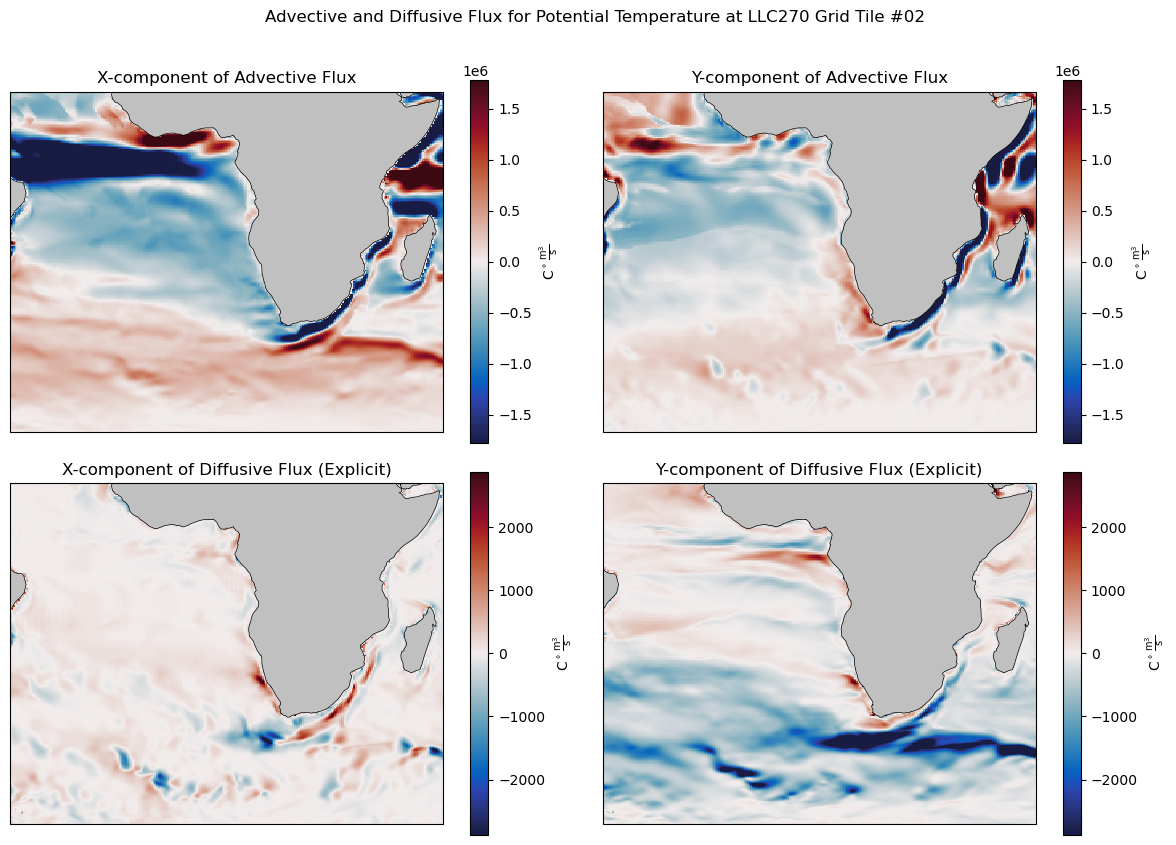

In [91]:
# max bounds scaled by powers of two
adv_max_bounds = (
    max(np.abs(np.min(advx)), np.max(advx), np.abs(np.min(advy)), np.max(advy)) // 8
)

df_max_bounds = (
    max(np.abs(np.min(dfx)), np.max(dfx), np.abs(np.min(dfy)), np.max(dfy)) // 16
)

# prepare lists of data and parameters
data_list = [advx, advy, dfx, dfy]
max_list = [adv_max_bounds, adv_max_bounds, df_max_bounds, df_max_bounds]
titles = [
    "X-component of Advective Flux",
    "Y-component of Advective Flux",
    "X-component of Diffusive Flux (Explicit)",
    "Y-component of Diffusive Flux (Explicit)",
]

fig, axs = plt.subplots(
    2, 2, figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()}
)

# plot the data using a loop
for idx, (data, max_bounds, title) in enumerate(zip(data_list, max_list, titles)):
    i = idx // 2  # Row index
    j = idx % 2  # Column index
    ax = axs[i, j]

    # preate the pcolormesh plot
    c = ax.pcolormesh(
        grid_0002_xc,
        grid_0002_yc,
        data,
        transform=ccrs.PlateCarree(),
        vmin=-max_bounds,
        vmax=max_bounds,
        cmap=ccm.balance,
        shading="nearest",
    )

    # add a colorbar
    fig.colorbar(
        c,
        ax=ax,
        orientation="vertical",
        label="$\\text{C}^\circ \\frac{\\text{m}^3}{\\text{s}}$",
    )

    # set the title
    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

# add features to all subplots
for ax in axs.flat:
    ax.add_feature(cfeature.LAND, zorder=2, facecolor="silver")
    ax.coastlines()

plt.tight_layout()
fig.suptitle(
    "Advective and Diffusive Flux for Potential Temperature at LLC270 Grid Tile #02",
    y=1.05,
);

## Part 6: Plot Magnitudes

To compare the difference advection and diffusion, we first need to compute the magnitude. The magnitude of a vector quantity is given by

$$
|\textbf{v}| = \sqrt{v_x^2 + v_y^2}
$$

Apply this formula to the fields above to produce fields of 2D advection and diffusion at the surface of the ocean.

In [92]:
adv_mag = np.sqrt(np.square(advx) + np.square(advy))
df_mag = np.sqrt(np.square(dfx) + np.square(dfy))

Now, plot the magnitudes of advection and diffusion. Since we are now working with magnitude rather than directional values, you should use a sequential colormap rather than a divergent colormap.

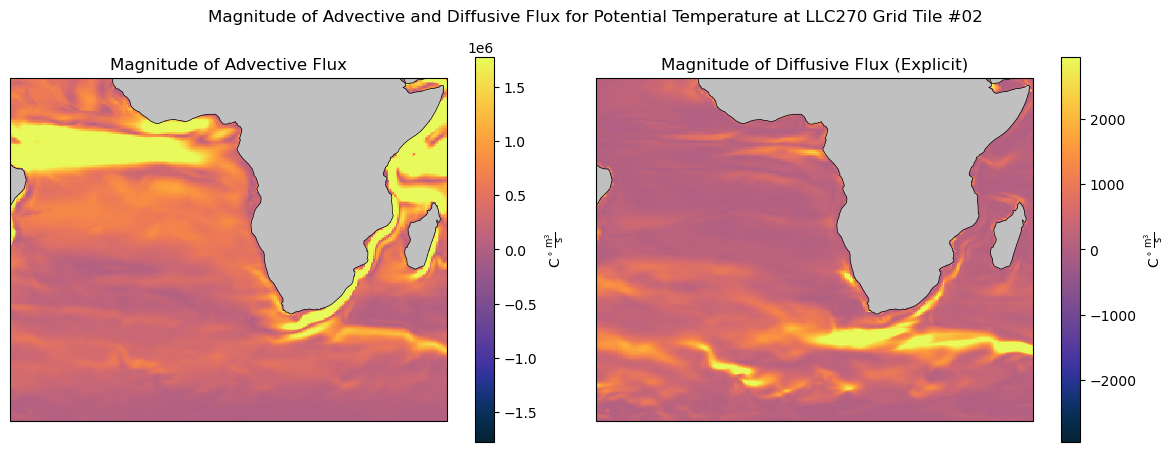

In [93]:
# determine max bounds and scale by powers of two
adv_mag_max_bounds = np.max(np.abs(adv_mag)) // 8
df_mag_max_bounds = np.max(np.abs(df_mag)) // 16

# prepare lists of data and parameters
data_list = [adv_mag, df_mag]
max_list = [adv_mag_max_bounds, df_mag_max_bounds]
titles = [
    "Magnitude of Advective Flux",
    "Magnitude of Diffusive Flux (Explicit)",
]

fig, axs = plt.subplots(
    1, 2, figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()}
)

# plot the data using a loop
for i, (data, max_bounds, title) in enumerate(zip(data_list, max_list, titles)):
    ax = axs[i]

    # preate the pcolormesh plot
    c = ax.pcolormesh(
        grid_0002_xc,
        grid_0002_yc,
        data,
        transform=ccrs.PlateCarree(),
        vmin=-max_bounds,
        vmax=max_bounds,
        cmap=ccm.thermal,
        shading="nearest",
    )

    # add a colorbar
    fig.colorbar(
        c,
        ax=ax,
        orientation="vertical",
        label="$\\text{C}^\circ \\frac{\\text{m}^3}{\\text{s}}$",
        shrink=0.5,
    )

    # set the title
    ax.set_title(title)

# add features to all subplots
for ax in axs.flat:
    ax.add_feature(cfeature.LAND, zorder=2, facecolor="silver")
    ax.coastlines()

plt.tight_layout()
fig.suptitle(
    "Magnitude of Advective and Diffusive Flux for Potential Temperature at LLC270 Grid Tile #02",
    y=0.8,
);

What is the mean ratio between advection and diffusion of temperature? Do a quick calculation below to compute the ratio. Be sure not to include points on land where the magnitude of each is 0.

In [94]:
adv_mag_nonzero = adv_mag[adv_mag != 0]
df_mag_nonzero = df_mag[df_mag != 0]
ratio = adv_mag_nonzero / df_mag_nonzero
mean_ratio = np.mean(ratio)
print(
    f"The mean ratio for the magnitudes of the advective and diffusive flux of potential temperatures is {mean_ratio:.02f}."
)

The mean ratio for the magnitudes of the advective and diffusive flux of potential temperatures is 6029.31.


## Part 7: Advection vs Diffusion

In the calculation above, we see that one process is responsible for transporting much more heat than the other. Which process is larger?

Suppose you would like to simplify the ocean model to be less computationally expensive. One way that you could achieve this is by removing processes from the model which have less of an effect on the model behavior than others. Based on the above plots and calculations, which process would you remove? Specifically, in the equation written in part 1, which term would you cancel from the equation?

### Solution:

$$
\frac{\partial \, \Theta}{\partial \, t} = -\overrightarrow{u} \cdot \nabla \Theta + \kappa \frac{\partial^2 \, \Theta}{\partial \, t^2} + \frac{J_H}{\rho \, C_p}
$$

For the equation above, the mean ratio is observed, $\approx 6029.31$. The mean ratio be represented as advective flux to diffusion flux and numerically abstracted to $6000:1$. With diffusion flux being negligible, the term $\kappa \frac{\partial^2 \, \Theta}{\partial \, t^2}$ will drop of the equation.

$$
\frac{\partial \, \Theta}{\partial \, t} = -\overrightarrow{u} \cdot \nabla \Theta + \frac{J_H}{\rho \, C_p}
$$